# Facies classification using Machine Learning


In [32]:
import sklearn

print(sklearn.__version__)

0.19.1


<hr />

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.

In [33]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

# filename = '../facies_vectors.csv'
# training_data = pd.read_csv(filename)
# training_data[training_data['Well Name'] == 'STUART']
%config InlineBackend.figure_format = 'retina'

# type(training_data.Depth[2])


In [34]:
train_set_df=pickle.load(open('/Users/zhiliwei/onedrive/科研总览/new_dissertation/my dessertation/1.intro/train_set_df.pickled','rb'))

In [35]:
test_set_df=pickle.load(open('/Users/zhiliwei/onedrive/科研总览/new_dissertation/my dessertation/1.intro/test_set_df.pickled','rb'))

In [36]:
blind = test_set_df
training_data = train_set_df

In [37]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

These are the names of the 10 training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone. 

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the `facies_vectors` dataframe.

In [38]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,4.503880,2907.308804,64.865990,0.658833,4.468016,13.215483,3.742031,1.519133,0.522110
std,2.474938,132.900638,30.174506,0.252715,5.252294,7.091140,0.840666,0.499701,0.285763
min,1.000000,2574.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2822.500000,44.710000,0.495000,1.667000,8.540000,3.150000,1.000000,0.278000
50%,4.000000,2933.000000,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000
75%,6.000000,3007.000000,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 4149 valid values except for `PE`, which has 3232.  In this tutorial we will drop the feature vectors that don't have a valid `PE` entry.

In [39]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,4.503880,2907.308804,64.865990,0.658833,4.468016,13.215483,3.742031,1.519133,0.522110
std,2.474938,132.900638,30.174506,0.252715,5.252294,7.091140,0.840666,0.499701,0.285763
min,1.000000,2574.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2822.500000,44.710000,0.495000,1.667000,8.540000,3.150000,1.000000,0.278000
50%,4.000000,2933.000000,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000
75%,6.000000,3007.000000,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [40]:
#I changed the colors to match the paper for easier compare.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

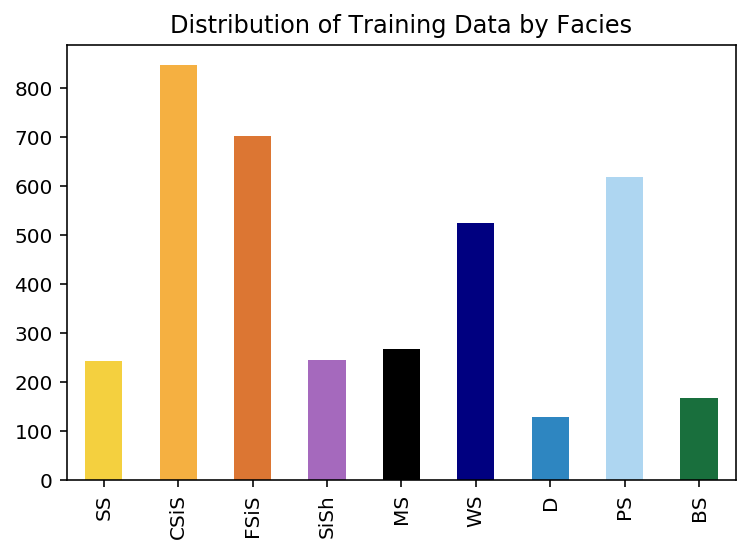

In [41]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)


facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

#light_rgb = colors.ListedColormap(facies_colors)
facies_counts.plot(kind='bar',color=facies_colors, 
                   
                   title='Distribution of Training Data by Facies')


## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [42]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,64.865990,0.658833,4.468016,13.215483,3.742031,1.519133,0.522110
std,30.174506,0.252715,5.252294,7.091140,0.840666,0.499701,0.285763
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,44.710000,0.495000,1.667000,8.540000,3.150000,1.000000,0.278000
50%,65.001000,0.639000,4.300000,12.050000,3.600000,2.000000,0.528000
75%,79.340000,0.821000,7.562000,16.059000,4.300000,2.000000,0.767000
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [43]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [44]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.3, random_state=42)

## Training the KNN classifier



In [45]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=30,weights='distance')


Now we can train the classifier using the training set we created above.

In [46]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [47]:
predicted_labels = clf.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    41    31     3                                        75
     CSiS     6   204    40                       1     1         252
     FSiS     4    66   131     1           1                     203
     SiSh           1          59     2    13     1     4          80
       MS           1     1    11    25    26          11          75
       WS                 1    14    16   100     2    24     3   160
        D                 2     8           4    20    10     1    45
       PS                 2     6     4    25     1   138    14   190
       BS                             1     1           3    37    42

Precision  0.80  0.67  0.73  0.60  0.52  0.59  0.80  0.72  0.67  0.68
   Recall  0.55  0.81  0.65  0.74  0.33  0.62  0.44  0.73  0.88  0.67
       F1  0.65  0.74  0.68  0.66  0.41  0.61  0.57  0.72  0.76  0.67


In [49]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [50]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [51]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.672906
Adjacent facies classification accuracy = 0.923351


In [52]:
display_adj_cm(conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    72           3                                        75
     CSiS         250                             1     1         252
     FSiS     4         197     1           1                     203
     SiSh           1          61          13     1     4          80
       MS           1     1          62                11          75
       WS                 1    14         142                 3   160
        D                 2     8                34           1    45
       PS                 2     6     4               178         190
       BS                             1     1                40    42

Precision  0.95  0.99  0.96  0.68  0.93  0.90  0.94  0.92  0.91  0.93
   Recall  0.96  0.99  0.97  0.76  0.83  0.89  0.76  0.94  0.95  0.92
       F1  0.95  0.99  0.96  0.72  0.87  0.90  0.84  0.93  0.93  0.92


## Applying the classification model to the blind data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [53]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
1071,1,B1 SH,SHANKLE,2842.0,52.720,0.590000,2.200,9.880,3.20000,1,0.367
2594,1,B4 SH,CROSS H CATTLE,2729.0,54.345,0.160168,1.400,16.200,2.97500,1,0.732
2600,1,B4 SH,CROSS H CATTLE,2732.0,61.969,0.157457,4.200,17.800,2.86300,1,0.625
2629,1,B4 SH,CROSS H CATTLE,2746.5,79.285,0.313234,5.100,14.750,2.84900,1,0.107
2551,1,B3 SH,CROSS H CATTLE,2708.0,68.186,0.519040,2.000,11.800,3.16200,1,0.540
...,...,...,...,...,...,...,...,...,...,...,...
1300,3,C SH,SHANKLE,2964.5,75.850,0.626000,1.800,21.045,2.90000,1,0.351
3920,3,B2 SH,CHURCHMAN BIBLE,3005.0,69.438,0.556000,-18.252,40.175,2.87900,1,0.417
1274,3,C SH,SHANKLE,2951.5,66.670,0.659000,10.700,14.420,3.20000,1,0.807
480,3,A1 SH,ALEXANDER D,2892.0,91.350,0.521000,7.400,15.330,3.13234,1,0.769


The label vector is just the `Facies` column:

In [54]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [55]:
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)

Now we can transform this with the scaler we made before:

In [56]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [57]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

Let's see how we did with the confusion matrix:

In [58]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.66
Optimized adjacent facies classification accuracy = 0.92


In [59]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    11    15                                              26
     CSiS     4    70    20                                        94
     FSiS     2    20    54     1                       1          78
     SiSh                 1    18           4           4          27
       MS     1     1           3     9    10     1     4          29
       WS           1     1     5     6    36     1     7     1    58
        D                       1           1     8     4          14
       PS           1           2     3    10          52          68
       BS                                         2     3    13    18

Precision  0.61  0.65  0.71  0.60  0.50  0.59  0.67  0.69  0.93  0.66
   Recall  0.42  0.74  0.69  0.67  0.31  0.62  0.57  0.76  0.72  0.66
       F1  0.50  0.69  0.70  0.63  0.38  0.61  0.62  0.73  0.81  0.65


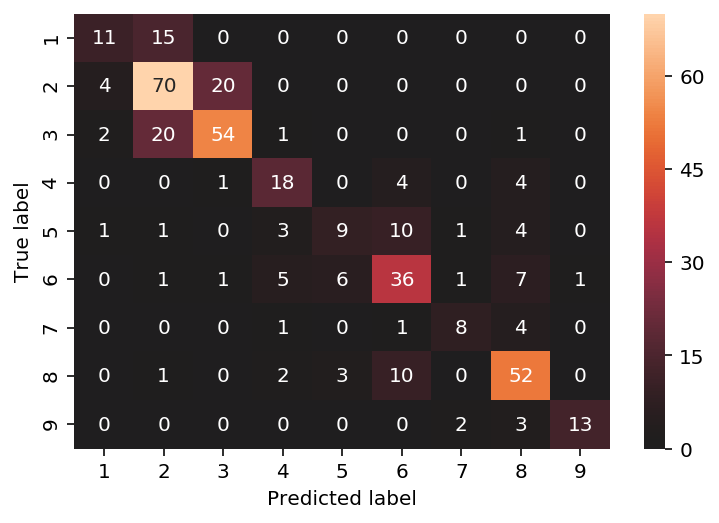

In [63]:
temp=['1','2','3','4','5','6','7','8','9']
import seaborn as sns
sns.heatmap(cv_conf,annot=True, center=True,fmt='d',xticklabels=temp,yticklabels=temp)
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.show()

...but does remarkably well on the adjacent facies predictions. 

In [60]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    26                                                    26
     CSiS          94                                              94
     FSiS     2          74     1                       1          78
     SiSh                 1    18           4           4          27
       MS     1     1                22           1     4          29
       WS           1     1     5          50                 1    58
        D                       1                13                14
       PS           1           2     3                62          68
       BS                                                    18    18

Precision  0.90  0.97  0.97  0.67  0.88  0.93  0.93  0.87  0.95  0.92
   Recall  1.00  1.00  0.95  0.67  0.76  0.86  0.93  0.91  1.00  0.92
       F1  0.95  0.98  0.96  0.67  0.81  0.89  0.93  0.89  0.97  0.91


In [61]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

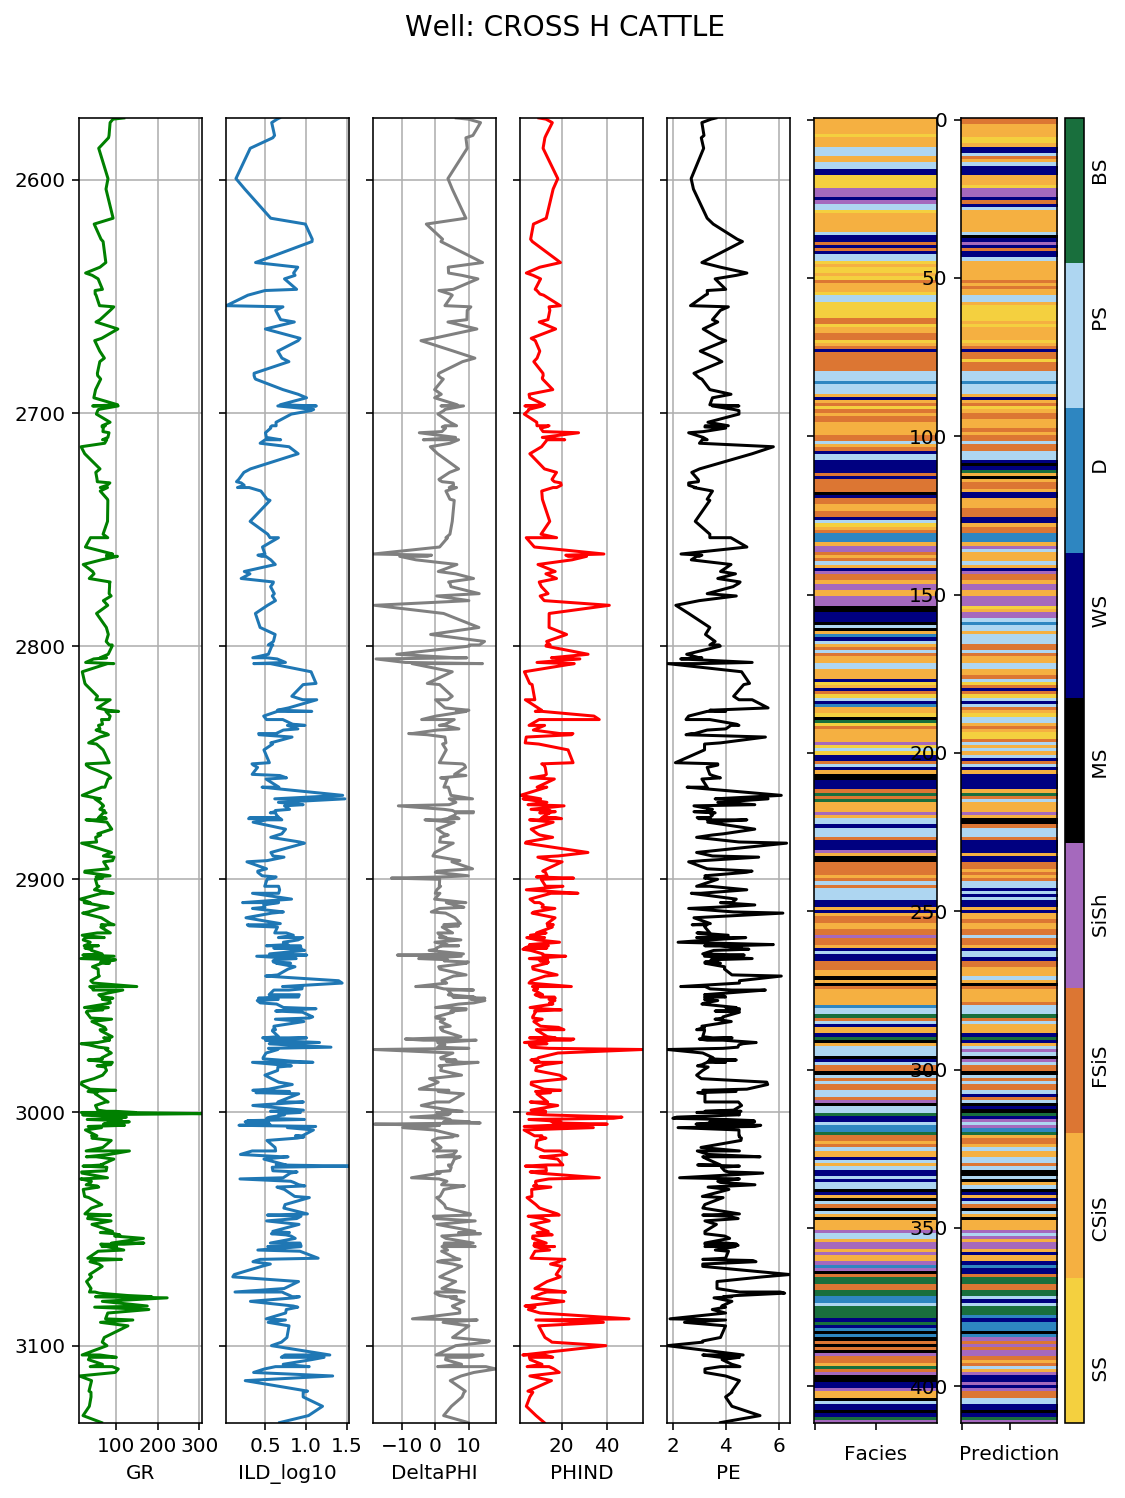

In [62]:
compare_facies_plot(blind, 'Prediction', facies_colors)

# add gridsearch() maybe?